In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from sunpy.coordinates import frames
import sunpy.map
from astropy.coordinates import SkyCoord
from astropy import units as u 
import datetime
import numpy as np 
from matplotlib.colors import LogNorm
import seaborn as sns
import scipy.stats
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import ScalarFormatter
from astropy.visualization import hist

from matplotlib import dates
from sunpy.time import parse_time
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.family'] = 'Helvetica'
sns.set_context("paper", font_scale=1.2)

# Read in flare lists

In [2]:
flare_list = pd.read_csv("flare_list_all_times_calc.csv")
flare_list["event_starttime"] = pd.to_datetime(flare_list["event_starttime"])
flare_list["event_endtime"] = pd.to_datetime(flare_list["event_endtime"])
flare_list["full_dur"] = [x.total_seconds() for x in (flare_list["event_endtime"]-flare_list["event_starttime"])]

flare_list["unique_day"] = pd.to_datetime(flare_list["event_starttime"].dt.strftime("%Y-%m-%d"))
flare_list["unique_month"] = pd.to_datetime(flare_list["event_starttime"].dt.strftime("%Y-%m"))

In [3]:
flare_list["goes_class_ind"].value_counts()

C    7800
M     748
X      49
Name: goes_class_ind, dtype: int64

## SSN data

In [4]:
def read_ssn():
    """
    Function just to read the SSN data from the downloaded csv file (see above for link)
    """

    ssn = pd.read_csv("/Users/laurahayes/spaceweather_stuff/SolarStatsStuff/SN_m_tot_V2.0.csv", names=['year', 'month', 'decimal_date', \
                                                  'ssn', 'ssn_dev', 'number_obs', 'indicator'], 
             delimiter=';')
    years = ssn['year'].values; months = ssn['month']
    tt = [datetime.datetime(ssn['year'][i], ssn['month'][i], 1) for i in range(len(ssn))]


    ssn['times'] = tt

    return ssn.set_index('times')

In [5]:
ssn = read_ssn()
ssn = ssn.truncate("2010-01-01", "2019-01-01")["ssn"]

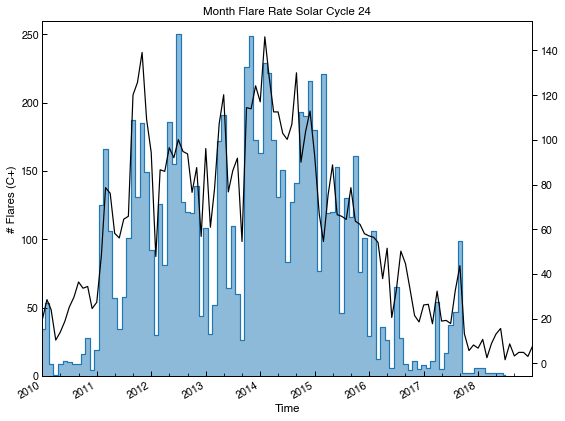

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
flare_list.groupby("unique_month")["goes_class_ind"].count().plot(drawstyle="steps-mid", axes=ax)


ax.xaxis.set_major_locator(dates.MonthLocator(interval=12))
ax.xaxis.set_minor_locator(dates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(dates.DateFormatter("%Y-%b"))
ax.set_xlabel("Time")
ax.set_ylabel("# Flares (C+)")
ax.set_title("Month Flare Rate Solar Cycle 24")
ax.tick_params(which="both", direction="in")
ax.set_xlim('2010-01-01', '2018-12-31')
ax.set_ylim(0, 260)
ax.fill_between(flare_list.groupby("unique_month")["goes_class_ind"].count().index, 
                flare_list.groupby("unique_month")["goes_class_ind"].count().values, 
                step="mid", alpha=0.5)

ax2 = ax.twinx()
ax2.plot(ssn, color="k")
plt.tight_layout()


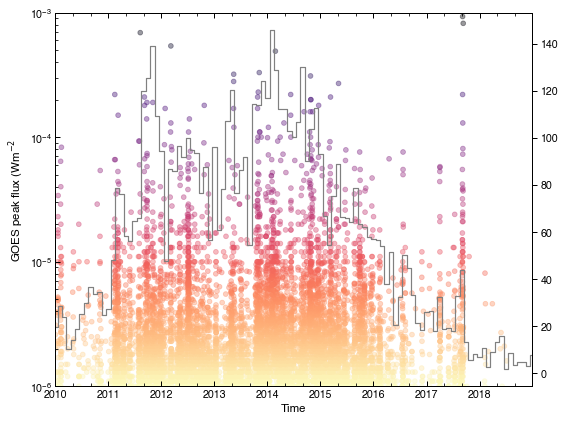

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
cmap=plt.get_cmap("magma_r")
cc = cmap(0.75)

plt.scatter(flare_list["event_starttime"], flare_list["goes_class_val"], c=flare_list["goes_class_val"], 
            cmap=cmap, alpha=0.4, norm=LogNorm())

ax.xaxis.set_major_locator(dates.MonthLocator(interval=12))
ax.xaxis.set_minor_locator(dates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(dates.DateFormatter("%Y"))

ax.set_xlabel("Time")
ax.set_ylabel("GOES peak flux (Wm$^{-2}$")
ax.set_yscale("log")
ax.set_ylim(1e-6, 1e-3)

ax2 = ax.twinx()
ax2.plot(ssn, color="grey", drawstyle="steps-mid")

ax.set_xlim(parse_time("2010-01-01").datetime, parse_time("2018-12-31").datetime)
ax.tick_params(which="both", direction="in",  top=True)
plt.tight_layout()

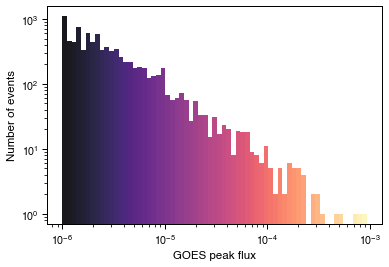

In [8]:
from matplotlib import colors
fig, ax = plt.subplots()
# first get the linear bins (bin size I just chose a random one)
n, linear_bins = np.histogram(flare_list['goes_class_val'], bins=65) 
# now define the log bins
logbins = np.logspace(np.log10(linear_bins[0]),np.log10(linear_bins[-1]),len(linear_bins))

n, bins, patches = ax.hist(flare_list['goes_class_val'], bins=logbins, alpha=0.9, color='green')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('GOES peak flux')
ax.set_ylabel('Number of events')

fracs = linear_bins
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.get_cmap('magma')(norm(thisfrac))
    thispatch.set_facecolor(color)


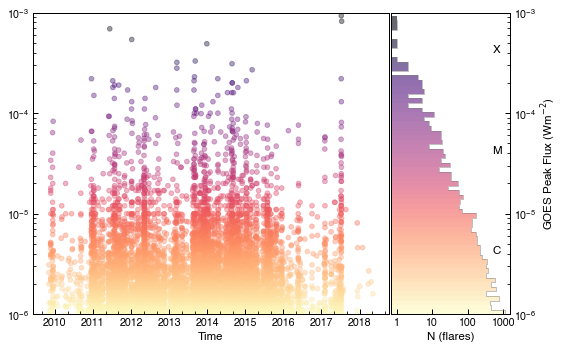

In [9]:
cmap="magma_r"
fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(8, 5))


ax01 = ax0
# ax0.set_xlim(parse_time("2010-01-01").datetime, parse_time("2018-12-31").datetime)
ax01.scatter(flare_list["event_starttime"], flare_list["goes_class_val"], c=flare_list["goes_class_val"], 
            cmap=cmap, alpha=0.4, norm=LogNorm())
ax01.xaxis.set_major_locator(dates.MonthLocator(interval=12))
ax01.xaxis.set_minor_locator(dates.MonthLocator(interval=4))
ax01.xaxis.set_major_formatter(dates.DateFormatter("%Y"))

ax01.set_xlabel("Time")
ax01.set_yscale("log")
ax01.set_ylim(1e-6, 1e-3)
ax01.tick_params(which='both',  direction='in', labelright=False)







# histogram
Na, binsa, patches = ax1.hist(flare_list['goes_class_val'], orientation='horizontal', 
                              bins=logbins, alpha=0.6)

ax1.step(Na, binsa[:-1], color='grey', lw=0.5) #overplot step

logbins = np.logspace(np.log10(linear_bins[0]),np.log10(linear_bins[-1]),len(linear_bins))

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(flare_list['goes_class_val'].min(), 5e-3)
ax1.tick_params(which='both',  direction='in', labelleft=False, labelright=True,  
                left=False, right=True)
ax1.set_ylabel('GOES Peak Flux (Wm$^{-2}$)')
ax1.yaxis.set_label_position("right")
ax1.set_xticks([1,10,100, 1000]) 
ax1.xaxis.set_major_formatter(ScalarFormatter())


ax1.set_ylim(1e-6, 1e-3)
fracs = linear_bins
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.get_cmap(cmap)(norm(thisfrac))
    thispatch.set_facecolor(color)

ax1.text(500, 4e-6, 'C', color='k', fontweight='bold')
ax1.text(500, 4e-5, 'M', color='k', fontweight='bold')
ax1.text(500, 4e-4, 'X', color='k', fontweight='bold')

ax1.set_xlabel('N (flares)')
plt.tight_layout()
plt.subplots_adjust(wspace=0.01)
plt.savefig("./plots/overall_flares.png", facecolor="w", dpi=300, bbox_inches="tight")

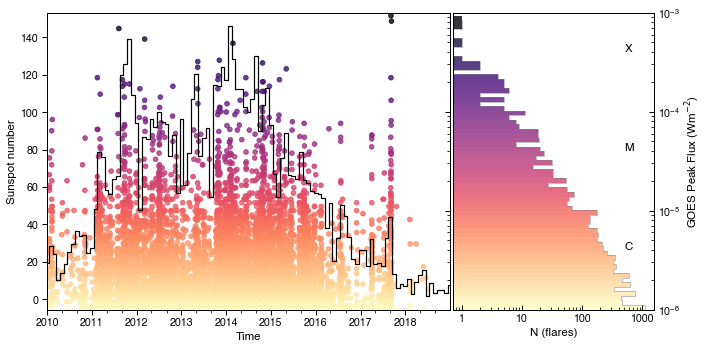

In [10]:
cmap="magma_r"
fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=(10, 5))

ax0.plot(ssn, color="k", lw=1.2, drawstyle="steps-mid")
ax0.set_zorder(1)  
ax0.patch.set_visible(False) 
ax0.set_ylabel("Sunspot number")

ax01 = ax0.twinx()
ax0.set_xlim(parse_time("2010-01-01").datetime, parse_time("2018-12-31").datetime)
ax01.scatter(flare_list["event_starttime"], flare_list["goes_class_val"], c=flare_list["goes_class_val"], 
            cmap=cmap, alpha=0.8, norm=LogNorm())
ax01.xaxis.set_major_locator(dates.MonthLocator(interval=12))
ax01.xaxis.set_minor_locator(dates.MonthLocator(interval=4))
ax01.xaxis.set_major_formatter(dates.DateFormatter("%Y"))

ax01.set_xlabel("Time")
ax01.set_yscale("log")
ax01.set_ylim(1e-6, 1e-3)
ax01.tick_params(which='both',  direction='in', labelright=False)



# histogram
Na, binsa, patches = ax1.hist(flare_list['goes_class_val'], orientation='horizontal', 
                              bins=logbins, alpha=0.8)

ax1.step(Na, binsa[:-1], color='grey', lw=0.5) #overplot step

logbins = np.logspace(np.log10(linear_bins[0]),np.log10(linear_bins[-1]),len(linear_bins))

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(flare_list['goes_class_val'].min(), 5e-3)
ax1.tick_params(which='both',  direction='in', labelleft=False, labelright=True,  
                left=False, right=True)
ax1.set_ylabel('GOES Peak Flux (Wm$^{-2}$)')
ax1.yaxis.set_label_position("right")
ax1.set_xticks([1,10,100, 1000]) 
ax1.xaxis.set_major_formatter(ScalarFormatter())


ax1.set_ylim(1e-6, 1e-3)
fracs = linear_bins
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.get_cmap(cmap)(norm(thisfrac))
    thispatch.set_facecolor(color)

ax1.text(500, 4e-6, 'C', color='k', fontweight='bold')
ax1.text(500, 4e-5, 'M', color='k', fontweight='bold')
ax1.text(500, 4e-4, 'X', color='k', fontweight='bold')

ax1.set_xlabel('N (flares)')
ax0.set_xlabel("Time")
plt.tight_layout()
plt.subplots_adjust(wspace=0.01)
plt.savefig("./plots/overall_flares_w_ssn.png", facecolor="w", dpi=300, bbox_inches="tight")

## Position plot

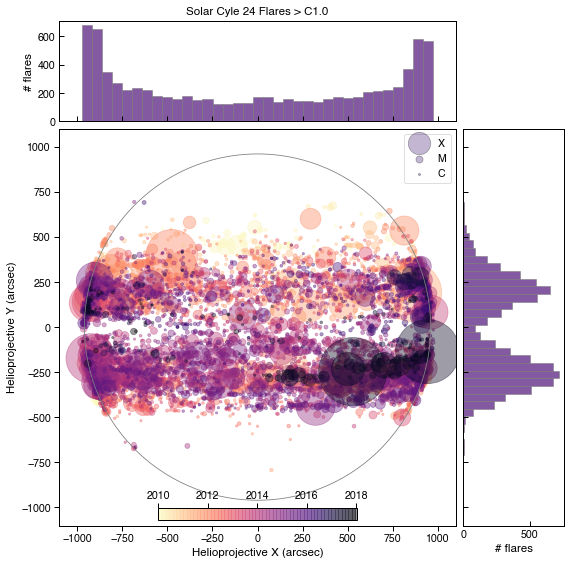

In [11]:

flares_p = flare_list[flare_list["hgs_lat"]>-60]
fig, ax = plt.subplots(figsize=(8, 8))

cmap = matplotlib.cm.get_cmap('magma_r')
cc = cmap(0.75)


axins1 = inset_axes(ax, 
                    width="50%",  # width = 50% of parent_bbox width
                    height="3%",  # height : 5%
                    loc='lower center')

# the scatter plot:
im = ax.scatter(flares_p["hpc_x"], flares_p["hpc_y"], alpha=0.4, s=5*flares_p["goes_class_val"]*1e6,
            c=flares_p["tt"]/60/60/60/60, cmap=cmap)
circle1 = plt.Circle((0, 0), 960, color='grey', fill=False)
ax.add_artist(circle1)
# Set aspect of the main axes.
ax.set_aspect("equal")
ax.set_xlim(-1100, 1100)
ax.set_ylim(-1100, 1100)


# create new axes on the right and on the top of the current axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("top", 1.4, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 1.4, pad=0.1, sharey=ax)

ax_histx.tick_params(labelbottom=False, direction="in")
ax_histy.tick_params(labelleft=False, direction="in")
# ax.tick_params(direction="in", right="in", top="in")

_ = ax_histx.hist(flares_p["hpc_x"], bins=35, color=cc, alpha=0.7,  edgecolor="grey")
_ = ax_histy.hist(flares_p["hpc_y"], bins=35, orientation='horizontal', color=cc, alpha=0.7, edgecolor="grey")

ax.set_xlabel("Helioprojective X (arcsec)")
ax.set_ylabel("Helioprojective Y (arcsec)")
ax_histx.set_ylabel("# flares")
ax_histy.set_xlabel("# flares")

ax_histx.set_title("Solar Cyle 24 Flares > C1.0")

cbar = fig.colorbar(im, cax=axins1, orientation="horizontal", ticks=[0, 5, 10, 15, 20])
axins1.set_xticklabels(['2010', '2012', '2014', '2016', '2018'], rotation=0) 
axins1.xaxis.tick_top()


ax.scatter(np.nan, np.nan, s=5*1e6*(1e-4), color=cmap(0.8), alpha=0.3, edgecolor="k", label="X")
ax.scatter(np.nan, np.nan, s=5*1e6*(1e-5), color=cmap(0.8), alpha=0.3, edgecolor="k", label="M")
ax.scatter(np.nan, np.nan, s=5*1e6*(1e-6), color=cmap(0.8), alpha=0.3, edgecolor="k", label="C")
ax.legend()
plt.tight_layout()
plt.savefig("./plots/flare_positions.png", facecolor="w", dpi=300, bbox_inches="tight")

## Flare durations

SpearmanrResult(correlation=0.12794585500801184, pvalue=9.144304932145375e-31)


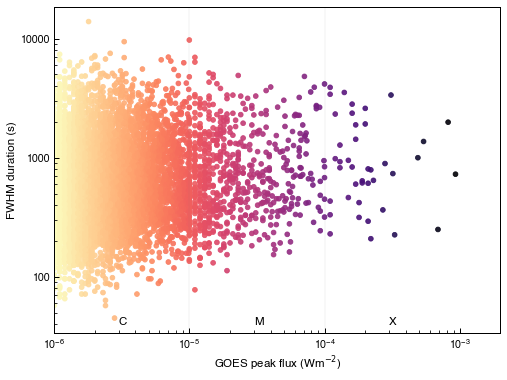

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(flare_list["goes_class_val"], flare_list["fwhm_dur"], alpha=0.9, c=flare_list["goes_class_val"], 
            norm=LogNorm(), cmap="magma_r")
plt.yscale("log")
plt.xscale("log")
plt.tick_params(which="both", direction="in")
plt.xlabel("GOES peak flux (Wm$^{-2}$)")
plt.ylabel("FWHM duration (s)")
plt.xlim(1e-6, 2e-3)


plt.axvline(1e-4, lw=0.1, color="grey")
plt.axvline(1e-5, lw=0.1, color="grey")
plt.axvline(1e-6, lw=0.1, color="grey")
ax.yaxis.set_major_formatter(ScalarFormatter())

ax.text(3e-6, 40, "C", color='k', fontweight='bold')
ax.text(3e-5, 40, "M", color='k', fontweight='bold')
ax.text(3e-4, 40, "X", color='k', fontweight='bold')

flare_list2 = flare_list[~flare_list["fwhm_dur"].isnull()]
print(scipy.stats.spearmanr(flare_list2["goes_class_val"], flare_list2["fwhm_dur"]))

plt.savefig("./plots/flare_fwhm_duration.png", facecolor="w", dpi=300, bbox_inches="tight")

In [38]:
flare_list4 = flare_list[np.isfinite(flare_list["integrated_flux"])]
flare_list4 = flare_list4[np.isfinite(flare_list4["fwhm_dur"])]

In [399]:
print(np.mean( flare_list["fwhm_dur"])/60)

13.86797287716011


In [400]:
print(10**(np.mean( np.log10(flare_list["fwhm_dur"])))/60)

9.923904596671914


In [398]:
print((np.mean( np.log10(flare_list["fwhm_dur"]))))

2.7748338309195164


## Active region data

In [179]:
ar_data = pd.read_csv("/Users/laurahayes/ml_project_flares/flare_analysis/AR_analysis/SRS_all_2010-2018.csv")
ar_data = ar_data[ar_data["ID"].isin(["I"])]
ar_data["matchtime"] = ar_data["date"]
ar_data["noaa_ar"] = ar_data["Number"]

In [181]:
flare_ar_df = pd.merge(flare_list, ar_data, how="left", on=["matchtime", "noaa_ar"])

In [182]:
flare_ar = flare_ar_df[flare_ar_df["noaa_ar"]!=0]

flare_x = flare_ar[flare_ar["goes_class_ind"].isin(["X"])]#.dropna()
flare_m = flare_ar[flare_ar["goes_class_ind"].isin(["M"])]#.dropna()
flare_c = flare_ar[flare_ar["goes_class_ind"].isin(["C"])]#.dropna()


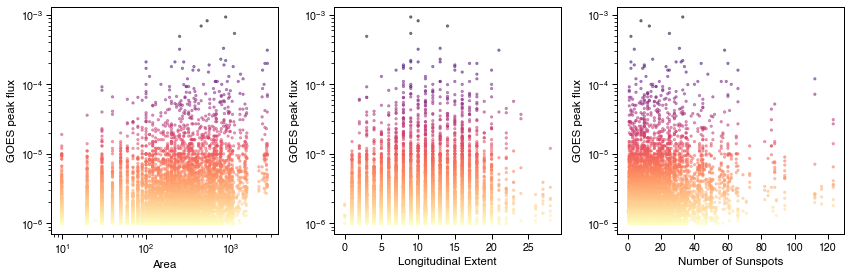

In [409]:
flare_ar_a = flare_ar[flare_ar["Area"]>0]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))


ax[0].scatter(flare_ar_a["Area"], flare_ar_a["goes_class_val"], marker='.', c=  flare_ar_a["goes_class_val"], 
              alpha=0.5, norm=LogNorm(), cmap=cmap)
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_ylabel("GOES peak flux")
ax[0].set_xlabel("Area")

ax[1].scatter(flare_ar["Longitudinal Extent"], flare_ar["goes_class_val"], marker='.', c=flare_ar["goes_class_val"], 
              alpha=0.5, norm=LogNorm(), cmap=cmap)
ax[1].set_yscale("log")
ax[1].set_ylabel("GOES peak flux")
ax[1].set_xlabel("Longitudinal Extent")

ax[2].scatter(flare_ar["Number of Sunspots"], flare_ar["goes_class_val"], marker='.',  c=flare_ar["goes_class_val"],
              alpha=0.5, norm=LogNorm(), cmap=cmap)
ax[2].set_yscale("log")
ax[2].set_ylabel("GOES peak flux")
ax[2].set_xlabel("Number of Sunspots")

plt.tight_layout()

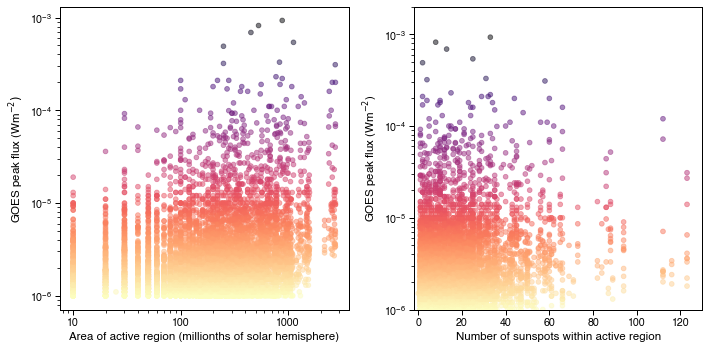

In [425]:
flare_ar_a = flare_ar[flare_ar["Area"]>0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))


ax[0].scatter(flare_ar_a["Area"], flare_ar_a["goes_class_val"],  c=  flare_ar_a["goes_class_val"], 
              alpha=0.5, norm=LogNorm(), cmap=cmap)
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_ylabel("GOES peak flux (Wm$^{-2})$")
ax[0].set_xlabel("Area of active region (millionths of solar hemisphere)")


ax[1].scatter(flare_ar["Number of Sunspots"], flare_ar["goes_class_val"],  c=flare_ar["goes_class_val"],
              alpha=0.5, norm=LogNorm(), cmap=cmap)
ax[1].set_yscale("log")
ax[1].set_ylabel("GOES peak flux (Wm$^{-2}$)")
ax[1].set_xlabel("Number of sunspots within active region")
ax[1].set_ylim(1e-6, 2e-3)
ax[1].set_ylim(1e-6, 2e-3)

ax[0].xaxis.set_major_formatter(ScalarFormatter())
ax[1].set_xlim(-2, 130)
plt.tight_layout()
plt.savefig("./plots/active_region_comps.png", dpi=300, facecolor="w", bbox_inches="tight")

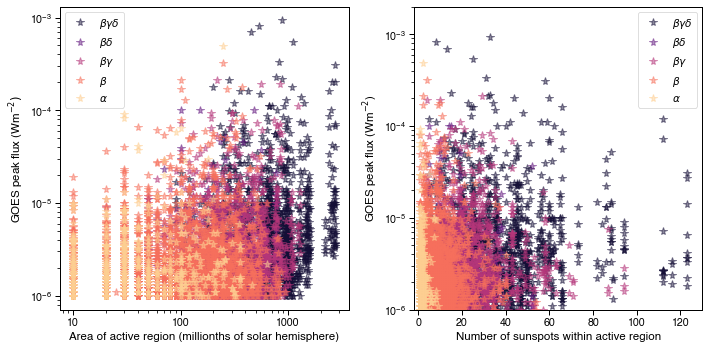

In [440]:
flare_ar_a = flare_ar[flare_ar["Area"]>0]

order = ['Alpha', 'Beta', 'Beta-Gamma',  'Beta-Delta',  'Beta-Gamma-Delta']
labels = [r'$\alpha$', r'$\beta$', r'$\beta\gamma$', r'$\beta\delta$', r'$\beta\gamma\delta$']
marker = ['o', '.', '+', '^', '*']
colors = ['pink', 'green', 'blue', 'yellow', 'red']
colors=plt.cm.magma_r(np.linspace(0.1,0.9,len(order)))

order=order[::-1]
colors=colors[::-1]
labels=labels[::-1]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))


for i in range(len(order)):
    aa = flare_ar_a[flare_ar_a["Mag Type"].isin([order[i]])]
    ax[0].plot(aa["Area"], aa["goes_class_val"], marker="*", ms=8, ls='', color=colors[i], alpha=0.5, 
             label=labels[i])
    ax[1].plot(aa["Number of Sunspots"], aa["goes_class_val"], marker="*", ms=8, ls='', color=colors[i], alpha=0.5, 
             label=labels[i])




# ax[0].scatter(flare_ar_a["Area"], flare_ar_a["goes_class_val"],  c=  flare_ar_a["goes_class_val"], 
#               alpha=0.5, norm=LogNorm(), cmap=cmap)
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].set_ylabel("GOES peak flux (Wm$^{-2})$")
ax[0].set_xlabel("Area of active region (millionths of solar hemisphere)")


# ax[1].scatter(flare_ar["Number of Sunspots"], flare_ar["goes_class_val"],  c=flare_ar["goes_class_val"],
#               alpha=0.5, norm=LogNorm(), cmap=cmap)
ax[1].set_yscale("log")
ax[1].set_ylabel("GOES peak flux (Wm$^{-2}$)")
ax[1].set_xlabel("Number of sunspots within active region")
ax[1].set_ylim(1e-6, 2e-3)
ax[1].set_ylim(1e-6, 2e-3)

ax[0].xaxis.set_major_formatter(ScalarFormatter())
ax[1].set_xlim(-2, 130)
plt.tight_layout()
ax[1].legend()
ax[0].legend()
plt.savefig("./plots/active_region_comps.png", dpi=300, facecolor="w", bbox_inches="tight")

In [198]:
flare_ar2 = flare_ar.dropna()

In [200]:
print(scipy.stats.spearmanr(flare_ar2["Number of Sunspots"], flare_ar2["goes_class_val"]))
print(scipy.stats.spearmanr(flare_ar2["Area"], flare_ar2["goes_class_val"]))
print(scipy.stats.spearmanr(flare_ar2["Longitudinal Extent"], flare_ar2["goes_class_val"]))

SpearmanrResult(correlation=0.18385120487258305, pvalue=1.0489505037196818e-46)
SpearmanrResult(correlation=0.22089946030648086, pvalue=3.9488090314759006e-67)
SpearmanrResult(correlation=0.18531034022130446, pvalue=1.9588644674250152e-47)


In [345]:
test_mag_type2 = 100*(test_mag_type/flare_ar3["goes_class_ind"].value_counts())

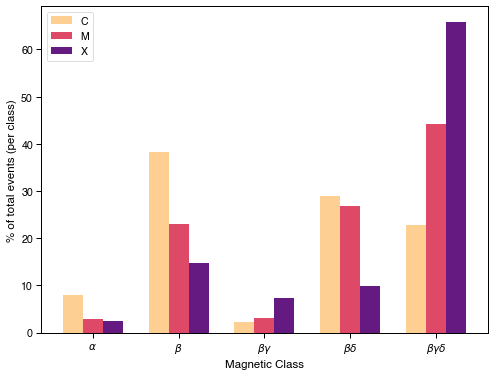

In [363]:
order = ['Alpha', 'Beta', 'Beta-Gamma',  'Beta-Delta',  'Beta-Gamma-Delta']
labels = [r'$\alpha$', r'$\beta$', r'$\beta\gamma$', r'$\beta\delta$', r'$\beta\gamma\delta$']
marker = ['o', '.', '+', '^', '*']
colors = ['pink', 'green', 'blue', 'yellow', 'red']
colors=plt.cm.magma_r(np.linspace(0.1,1,4))


fig, ax = plt.subplots(figsize=(8, 6))
test_mag_type2.plot.bar(color=colors, ax=ax, width=0.7)
ax.legend(["C", "M", "X"])
ax.set_xticklabels(labels, rotation=0)
ax.set_xlabel("Magnetic Class")
ax.set_ylabel("% of total events (per class)")
plt.savefig("./plots/breakdown_class_flares.png", facecolor="w", dpi=300, bbox_inches="tight")

# Unique active regions

In [347]:
order_df = {'Alpha':1, 'Beta':2, 'Beta-Gamma':3,  'Beta-Delta':4,  'Beta-Gamma-Delta':5}
flare_ar["mag_type_no"] = flare_ar["Mag Type"].map(order_df)

In [348]:
unique_ar = flare_ar["noaa_ar"].unique()
max_events = []
for ar in unique_ar:
    unique_df = flare_ar[flare_ar.noaa_ar.isin([ar])]
    event = {}
    event["ar_num"] = ar
    event["number_flares"] = len(unique_df)
    event["c_flares"] = np.sum(unique_df["goes_class_ind"].isin(["C"]))
    event["m_flares"] = np.sum(unique_df["goes_class_ind"].isin(["M"]))
    event["x_flares"] = np.sum(unique_df["goes_class_ind"].isin(["X"]))
    event["max_flare"] = np.max(unique_df["goes_class_val"])
    event["max_area"] = np.max(unique_df["Area"])
    event["max_sunspots"] = np.max(unique_df["Number of Sunspots"])    
    event["ar_class_max"] = unique_df.iloc[np.argmax(unique_df["goes_class_val"])]["Mag Type"]
    event["largest_mag_class"] = unique_df.iloc[np.argmax(unique_df["mag_type_no"])]["Mag Type"]
    max_events.append(event)

max_events = pd.DataFrame(max_events)

Text(0, 0.5, 'Max X-ray flux (Wm$^{-2}$)')

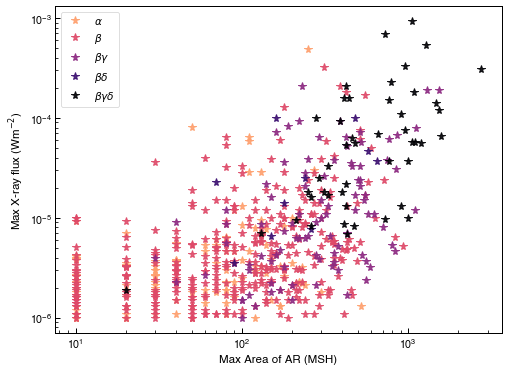

In [359]:
order = ['Alpha', 'Beta', 'Beta-Gamma',  'Beta-Delta',  'Beta-Gamma-Delta']
labels = [r'$\alpha$', r'$\beta$', r'$\beta\gamma$', r'$\beta\delta$', r'$\beta\gamma\delta$']
marker = ['o', '.', '+', '^', '*']
colors = ['pink', 'green', 'blue', 'yellow', 'red']
colors=plt.cm.magma_r(np.linspace(0.2,1,len(order)))
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(len(order)):
    aa = events[max_events["ar_class_max"].isin([order[i]])]
    plt.plot(aa["max_area"], aa["max_flare"], marker="*", ms=8, ls='', color=colors[i], alpha=0.9, 
             label=labels[i])

plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.tick_params(which="both", direction="in")
plt.xlabel("Max Area of AR (MSH)")
plt.ylabel("Max X-ray flux (Wm$^{-2}$)")

Text(0, 0.5, 'Max X-ray flux (Wm$^{-2}$)')

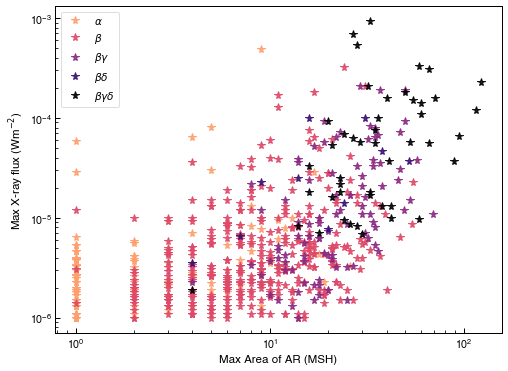

In [361]:
order = ['Alpha', 'Beta', 'Beta-Gamma',  'Beta-Delta',  'Beta-Gamma-Delta']
labels = [r'$\alpha$', r'$\beta$', r'$\beta\gamma$', r'$\beta\delta$', r'$\beta\gamma\delta$']
marker = ['o', '.', '+', '^', '*']
colors = ['pink', 'green', 'blue', 'yellow', 'red']
colors=plt.cm.magma_r(np.linspace(0.2,1,len(order)))
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(len(order)):
    aa = events[max_events["ar_class_max"].isin([order[i]])]
    plt.plot(aa["max_sunspots"], aa["max_flare"], marker="*", ms=8, ls='', color=colors[i], alpha=0.9, 
             label=labels[i])

plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.tick_params(which="both", direction="in")
plt.xlabel("Max Area of AR (MSH)")
plt.ylabel("Max X-ray flux (Wm$^{-2}$)")

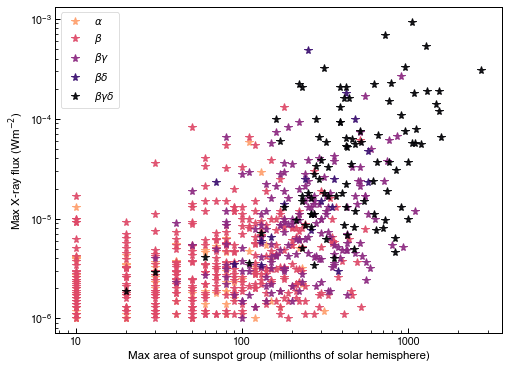

In [441]:
order = ['Alpha', 'Beta', 'Beta-Gamma',  'Beta-Delta',  'Beta-Gamma-Delta']
labels = [r'$\alpha$', r'$\beta$', r'$\beta\gamma$', r'$\beta\delta$', r'$\beta\gamma\delta$']
marker = ['o', '.', '+', '^', '*']
colors = ['pink', 'green', 'blue', 'yellow', 'red']
colors=plt.cm.magma_r(np.linspace(0.2,1,len(order)))
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(len(order)):
    aa = max_events[max_events["largest_mag_class"].isin([order[i]])]
    plt.plot(aa["max_area"], aa["max_flare"], marker="*", ms=8, ls='', color=colors[i], alpha=0.9, 
             label=labels[i])

plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.tick_params(which="both", direction="in")
plt.xlabel("Max area of sunspot group (millionths of solar hemisphere)")
plt.ylabel("Max X-ray flux (Wm$^{-2}$)")
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.savefig("./plots/max_area_flare.png", facecolor="w", dpi=300, bbox_inches="tight")

## Flaring rate

In [324]:
plt.plot(max_events["number_flares"]

0       4
1       5
2      24
3      39
4       5
       ..
809     6
810     1
811     1
812     3
813     1
Name: number_flares, Length: 814, dtype: int64